# La sinistralité automobile

In [276]:
import pandas as pd
from functools import reduce
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from pandas.api.types import is_numeric_dtype
import squarify
from matplotlib import rc
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
import folium

In [277]:
lieux=pd.read_csv('lieux-2018.csv')
carac=pd.read_csv('caracteristiques-2018.csv',encoding='latin-1')
usagers=pd.read_csv('usagers-2018.csv')
vehicules=pd.read_csv('vehicules-2018.csv')

C:\Users\Amin\Anaconda3\envs\GPU\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# EDA & Prétraitement des données & Features engineering

# Caractéristiques 

In [278]:
carac.shape

(57783, 16)

In [279]:
len(carac["Num_Acc"].unique())==carac.shape[0]

True

> Num_Acc est unique pour la base caractéristiques.

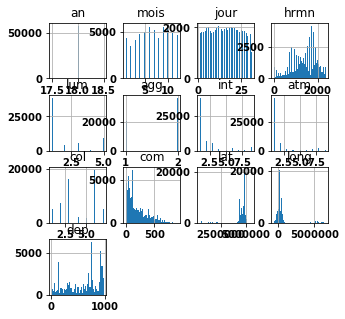

In [280]:
carac.drop(columns=['Num_Acc']).hist(figsize=(5,5),bins=50);

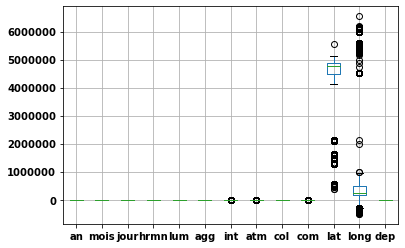

In [281]:
carac.iloc[:,1:].boxplot();

In [282]:
carac.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57783 entries, 0 to 57782
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Num_Acc  57783 non-null  int64  
 1   an       57783 non-null  int64  
 2   mois     57783 non-null  int64  
 3   jour     57783 non-null  int64  
 4   hrmn     57783 non-null  int64  
 5   lum      57783 non-null  int64  
 6   agg      57783 non-null  int64  
 7   int      57783 non-null  int64  
 8   atm      57778 non-null  float64
 9   col      57781 non-null  float64
 10  com      57783 non-null  int64  
 11  adr      57228 non-null  object 
 12  gps      57733 non-null  object 
 13  lat      55960 non-null  float64
 14  long     55960 non-null  float64
 15  dep      57783 non-null  int64  
dtypes: float64(4), int64(10), object(2)
memory usage: 7.1+ MB


**Variables qualitatives :**
- hrmn : Heure et minutes de l'accident
- lum  : Conditions d’éclairage dans lesquelles l'accident s'est produit 
- dep  : Code département INSEE
- com  :  Le numéro de commune est un code donné par l‘INSEE. Le code comporte 3 chiffres calés à droite. 
- agg  : Localisation
- int  : Intersection
- atm  : Conditions atmosphériques
- col  : Type de collision
- adr  : Adresse posta
- gps  : Codage GPS

**Variables quantitatives :**
- jour : Jour de l'accident
- mois : Mois de l'accident
- an : Année de l'accident
- lat : Latitude
- long : Longitude

In [283]:
for i in carac.columns:
    print(carac[i].describe())

count    5.778300e+04
mean     2.018000e+11
std      1.668066e+04
min      2.018000e+11
25%      2.018000e+11
50%      2.018000e+11
75%      2.018000e+11
max      2.018001e+11
Name: Num_Acc, dtype: float64
count    57783.0
mean        18.0
std          0.0
min         18.0
25%         18.0
50%         18.0
75%         18.0
max         18.0
Name: an, dtype: float64
count    57783.000000
mean         6.743350
std          3.347513
min          1.000000
25%          4.000000
50%          7.000000
75%         10.000000
max         12.000000
Name: mois, dtype: float64
count    57783.000000
mean        15.705484
std          8.702884
min          1.000000
25%          8.000000
50%         16.000000
75%         23.000000
max         31.000000
Name: jour, dtype: float64
count    57783.000000
mean      1375.970182
std        547.166704
min          1.000000
25%        950.000000
50%       1445.000000
75%       1810.000000
max       2359.000000
Name: hrmn, dtype: float64
count    57783.000000
me

- La variable "an" est toujours égale à 18.
- La valeur 0 n'est pas utilisé pour remplacer les valeurs nulles.

In [284]:
del carac['an']

In [285]:
missing_carac=carac.isna().sum()
missing_carac_perc=carac.isna().sum()/carac.shape[0]
df_info_carac=pd.concat([missing_carac,missing_carac_perc],keys=['Values','Percentage'],axis=1)

In [286]:
df_info_carac[df_info_carac['Percentage']>0].sort_values(by=['Percentage'],ascending=False)

,Values,Percentage
lat,1823,0.031549
long,1823,0.031549
adr,555,0.009605
gps,50,0.000865
atm,5,0.000087
col,2,0.000035


C:\Users\Amin\Anaconda3\envs\GPU\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


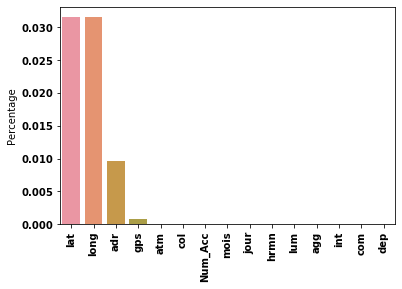

In [287]:
plot_carac_info=sns.barplot(df_info_carac.sort_values(by=['Percentage'],ascending=False).index,df_info_carac['Percentage'].sort_values(ascending=False))
plot_carac_info.set_xticklabels(plot_carac_info.get_xticklabels(),rotation=90);

In [288]:
carac.isna().sum().sum()*100/(carac.shape[0]*carac.shape[1])

0.4912632896642034

> La meilleure solution pour se débarrasser des valeurs nulles dans ce cas est d'éliminer les lignes, on gardera quand même 99% des données.

In [289]:
for i in carac.columns:
    carac = carac[carac[i].notna()]
    carac.reset_index(drop=True,inplace=True)

In [290]:
carac['int'].value_counts()

1    36658
2     6770
3     5626
9     2190
6     2046
4     1126
7      662
5      259
8       68
Name: int, dtype: int64

> Pour minimiser le nombre des modalités, je me suis basé sur la description comme référence. 

##### Encodage et recodage :

##### "int"

In [291]:
carac["int"]= carac["int"].replace({1 : "1", 2 : "2", 3 : "2", 4 : "2", 5 : "2", 6 : "3", 7 : "4", 8 : "5", 9 : "6"})                     

##### "atm"

In [292]:
carac["atm"]= carac["atm"].replace({9 : 0, 7 : 1, 8 : 1, 1 : 1 , 2 : 1, 2 : 2, 3 : 3, 4 : 3, 5 : 4, 6 : 5})                     

##### "col"

In [293]:
carac["col"]= carac["col"].replace({7 : 0, 1 : 1 , 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 :3})                     

##### Création d'une variable jour : 7 modalités

In [294]:
import datetime

In [295]:
jourSemaine=[]
for i in range(carac.shape[0]):    
    jourSemaine.append(datetime.datetime(2018, carac['mois'][i], carac['jour'][i]).weekday())    

In [296]:
df_jourSemaine=pd.DataFrame(data=jourSemaine,columns=['jourSemaine'])

In [297]:
carac=pd.concat([carac, df_jourSemaine], axis=1)

##### Création de la variable heure_pointe

##### L'idée d'utiliser l'heure n'est que pour distinguer si l'accident a eu en heure de pointe ou non.
##### Généralement en France entre 7 et 9 heures, on parle alors « d'heure de pointe du matin ») puis lorsqu'ils rentrent à leur domicile (entre 17 et 20 heures, on parle alors « d'heure de pointe du soir. 
##### Durant les heures de pointe le nombre des accidents augmente vu que les voitures roulent assez vite.

In [298]:
heure=[]
minute=[]
for i in range(carac.shape[0]):
    if len(str(carac['hrmn'][i])) == 4:
        heure.append(int(str(carac['hrmn'][i])[0:2]))
        minute.append(int(str(carac['hrmn'][i])[2:4]))
    elif  len(str(carac['hrmn'][i])) == 3:
        heure.append(int(str(carac['hrmn'][i])[0:1]))
        minute.append(int(str(carac['hrmn'][i])[1:3]))
    else :
        heure.append(0)
        minute.append(int(str(carac['hrmn'][i])))

In [299]:
hm = {'Heure':heure,'Minute':minute}

In [300]:
heure_min=pd.DataFrame(hm)

In [301]:
carac=pd.concat([carac, heure_min], axis=1)

In [302]:
time=[]
for i in range(carac.shape[0]):    
    time.append(datetime.datetime(2018, carac['mois'][i], carac['jour'][i],carac['Heure'][i],carac['Minute'][i]).time())  

In [303]:
heure_pointe=[]
for i in time:
    if ((i > datetime.time(7,0))&(i<datetime.time(9,0))) | ((i >datetime.time(17,0))&(i<datetime.time(20,0))):    
        heure_pointe.append(1)
    else :
        heure_pointe.append(0)

In [304]:
hp = {'heure_pointe':heure_pointe}
heure_pointe=pd.DataFrame(hp)
carac=pd.concat([carac, heure_pointe], axis=1)

In [305]:
del carac['jour']
del carac['Heure']
del carac['Minute']
del carac['hrmn']

##### Vu que nous avant les coordonnées de l'accident, on peut éliminer les autres variables qui ont un rapport avec l'emplacement notamment : "adr" , "com", "dep" et "gps". ( Sachant que leur encodage nous coutera beaucoup d'espace. )

In [306]:
del carac['adr']
del carac['com']
del carac['dep']
del carac['gps']

In [307]:
carac.columns

Index(['Num_Acc', 'mois', 'lum', 'agg', 'int', 'atm', 'col', 'lat', 'long',
       'jourSemaine', 'heure_pointe'],
      dtype='object')

In [308]:
lundi=carac[carac['jourSemaine']==0]['Num_Acc'].count()
mardi=carac[carac['jourSemaine']==1]['Num_Acc'].count()
mercredi=carac[carac['jourSemaine']==2]['Num_Acc'].count()
jeudi=carac[carac['jourSemaine']==3]['Num_Acc'].count()
vendredi=carac[carac['jourSemaine']==4]['Num_Acc'].count()
samedi=carac[carac['jourSemaine']==5]['Num_Acc'].count()
dimanche=carac[carac['jourSemaine']==6]['Num_Acc'].count()

In [309]:
labels=["Lundi","Mardi","Mercredi","Jeudi","Vendredi","Samedi","Dimanche"]
size=[lundi,mardi,mercredi,jeudi,vendredi,samedi,dimanche]

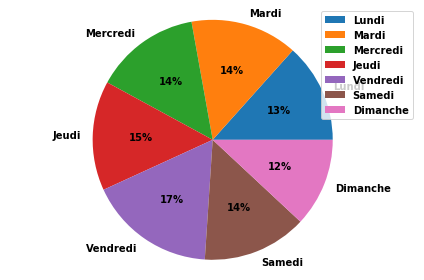

In [310]:
plt.pie(size, labels=labels, autopct='%1.0f%%')
l = plt.legend(labels, loc="best")
for text in l.get_texts():
    text.set_color("black")
plt.axis('equal')
plt.tight_layout()
plt.show()

In [311]:
hp=carac[carac['heure_pointe']==1]['Num_Acc'].count()
nhp=carac[carac['heure_pointe']==0]['Num_Acc'].count()

C:\Users\Amin\Anaconda3\envs\GPU\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


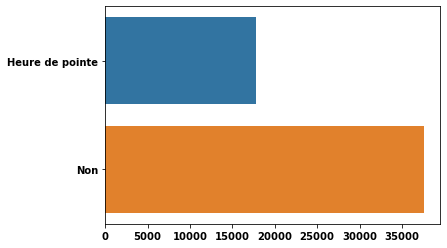

In [312]:
sns.barplot([hp,nhp],['Heure de pointe','Non']);

In [313]:
jour=carac[carac['lum'].isin([1,2])]['Num_Acc'].count()
nuit=carac[carac['lum'].isin([3,4,5])]['Num_Acc'].count()

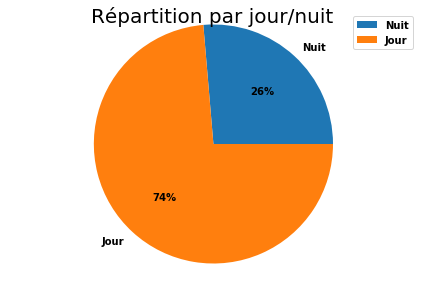

In [314]:
size=[nuit,jour]
labels=["Nuit","Jour"]

plt.pie(size, labels=labels, autopct='%1.0f%%')
l = plt.legend(labels, loc="best")
for text in l.get_texts():
    text.set_color("black")
fig = plt.gcf()
fig.suptitle("Répartition par jour/nuit", fontsize=20,color="black")       
plt.axis('equal')
plt.tight_layout()
plt.show()

In [315]:
janvier=carac[carac['mois']==1]['Num_Acc'].count()
février=carac[carac['mois']==2]['Num_Acc'].count()
mars=carac[carac['mois']==3]['Num_Acc'].count()
avril=carac[carac['mois']==4]['Num_Acc'].count()
mai=carac[carac['mois']==5]['Num_Acc'].count()
juin=carac[carac['mois']==6]['Num_Acc'].count()
juillet=carac[carac['mois']==7]['Num_Acc'].count()
aout=carac[carac['mois']==8]['Num_Acc'].count()
septembre=carac[carac['mois']==9]['Num_Acc'].count()
octobre=carac[carac['mois']==10]['Num_Acc'].count()
novembre=carac[carac['mois']==11]['Num_Acc'].count()
décembre=carac[carac['mois']==12]['Num_Acc'].count()

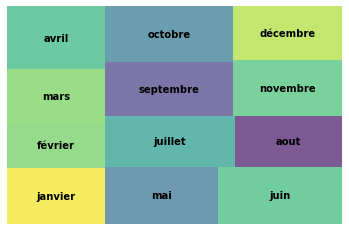

In [316]:
squarify.plot(sizes=[janvier,février,mars,avril,mai,juin,juillet,aout,septembre,octobre,novembre,décembre], label=["janvier","février","mars","avril","mai","juin","juillet","aout","septembre","octobre","novembre","décembre"], alpha=.7 )
plt.axis('off')
plt.show()

In [317]:
carac

,Num_Acc,mois,lum,agg,int,atm,col,lat,long,jourSemaine,heure_pointe
0,201800000001,1,1,1,2,1.0,1.0,5055737.0,294992.0,2,0
1,201800000002,2,1,2,4,1.0,0.0,5052936.0,293151.0,0,0
2,201800000003,3,1,2,2,1.0,0.0,5051243.0,291714.0,6,0
3,201800000004,5,1,2,1,1.0,1.0,5051974.0,289123.0,5,1
4,201800000005,6,1,2,1,1.0,1.0,5051607.0,290605.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
55400,201800057779,12,1,2,1,1.0,3.0,1280217.0,4521356.0,5,0
55401,201800057780,12,2,2,1,1.0,1.0,1278120.0,4523436.0,6,0
55402,201800057781,12,5,2,1,1.0,3.0,1276930.0,4522409.0,5,0
55403,201800057782,12,5,2,1,1.0,1.0,1278622.0,4522036.0,6,1


# Lieux 

In [318]:
lieux.shape

(57783, 18)

In [319]:
len(lieux["Num_Acc"].unique())==lieux.shape[0]

True

> Num_Acc est unique pour la base lieux.

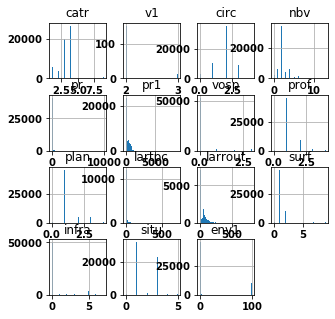

In [320]:
lieux.drop(columns=['Num_Acc']).hist(figsize=(5,5),bins=50);

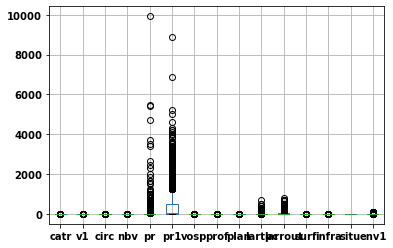

In [321]:
lieux.iloc[:,1:].boxplot();

In [322]:
lieux.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57783 entries, 0 to 57782
Data columns (total 18 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Num_Acc  57783 non-null  int64  
 1   catr     57783 non-null  int64  
 2   voie     35890 non-null  object 
 3   v1       167 non-null    float64
 4   v2       2701 non-null   object 
 5   circ     57378 non-null  float64
 6   nbv      57276 non-null  float64
 7   pr       42008 non-null  float64
 8   pr1      41735 non-null  float64
 9   vosp     57258 non-null  float64
 10  prof     57344 non-null  float64
 11  plan     57363 non-null  float64
 12  lartpc   13293 non-null  float64
 13  larrout  13709 non-null  float64
 14  surf     57341 non-null  float64
 15  infra    57317 non-null  float64
 16  situ     57289 non-null  float64
 17  env1     57324 non-null  float64
dtypes: float64(14), int64(2), object(2)
memory usage: 7.9+ MB


Variables qualitatives :
- catr : Catégorie de route 
- voie : Numéro de la route
- V1 : Indice numérique du numéro de route
- V2 : Lettre indice alphanumérique de la route
- circ : Régime de circulation
- vosp : Signale l’existence d’une voie réservée
- prof : Profil en long décrit la déclivité de la route à l'endroit de l'accident 
- pr : Numéro du PR de rattachement 
- plan : Tracé en plan
- surf : Etat de la surface
- infra : Aménagement - Infrastructure 
- situ : Situation de l’accident 
- env1 : Indique si l’accident s’est produit à proximité d’une école

Variables quantitatives :
- nbv : Nombre total de voies de circulation
- pr1 : Distance en mètres au PR 
- lartpc : Largeur du terre plein central (TPC) s'il existe
- larrout : Largeur de la chaussée affectée à la circulation des véhicules

In [323]:
for i in lieux.columns:
    print(lieux[i].describe())

count    5.778300e+04
mean     2.018000e+11
std      1.668066e+04
min      2.018000e+11
25%      2.018000e+11
50%      2.018000e+11
75%      2.018000e+11
max      2.018001e+11
Name: Num_Acc, dtype: float64
count    57783.000000
mean         3.320233
std          1.175553
min          1.000000
25%          3.000000
50%          3.000000
75%          4.000000
max          9.000000
Name: catr, dtype: float64
count     35890.0
unique     1534.0
top           0.0
freq       3786.0
Name: voie, dtype: float64
count    167.000000
mean       2.083832
std        0.277970
min        2.000000
25%        2.000000
50%        2.000000
75%        2.000000
max        3.000000
Name: v1, dtype: float64
count     2701
unique      42
top          D
freq      1176
Name: v2, dtype: object
count    57378.000000
mean         1.893443
std          0.732030
min          0.000000
25%          2.000000
50%          2.000000
75%          2.000000
max          4.000000
Name: circ, dtype: float64
count    57276.00000

> Pour les variables : cir,vosp,prof,plan,larpc,larrout,surf,infra,situ,env1, la valeur 0 est  utilisé pour dire que l'information n'est pas renseingée ou n'existe pas.


In [324]:
missing_lieux=lieux.isna().sum()
missing_lieux_perc=lieux.isna().sum()/lieux.shape[0]
df_info_lieux=pd.concat([missing_lieux,missing_lieux_perc],keys=['Values','Percentage'],axis=1)

In [325]:
df_info_lieux[df_info_lieux['Percentage']>0].sort_values(by=['Percentage'],ascending=False)

,Values,Percentage
v1,57616,0.997110
v2,55082,0.953256
lartpc,44490,0.769950
larrout,44074,0.762750
voie,21893,0.378883
pr1,16048,0.277729
pr,15775,0.273004
vosp,525,0.009086
nbv,507,0.008774
situ,494,0.008549


C:\Users\Amin\Anaconda3\envs\GPU\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


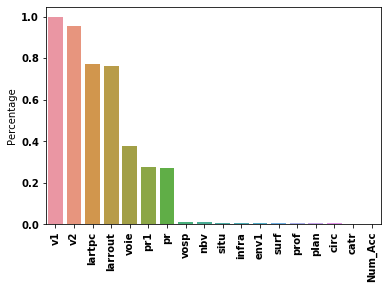

In [326]:
plot_lieux_info=sns.barplot(df_info_lieux.sort_values(by=['Percentage'],ascending=False).index,df_info_lieux['Percentage'].sort_values(ascending=False))
plot_lieux_info.set_xticklabels(plot_lieux_info.get_xticklabels(),rotation=90);

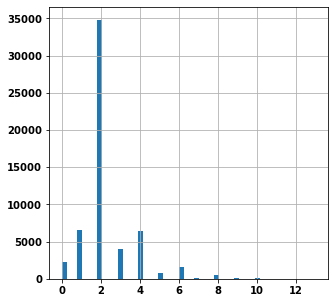

In [327]:
lieux['nbv'].hist(figsize=(5,5),bins=50);

In [328]:
lieux.isna().sum().sum()*100/(lieux.shape[0]*lieux.shape[1])

24.914575028795475

> Pour les variables v1,v2,lartpc,larrout,voie,pr1 et pr le taux des valeurs nulles dépasses 30%, donc leur élimination et le meilleur choix.

In [329]:
for i in ["v1","v2","lartpc","larrout","voie","pr1","pr"]:
    del lieux[i]

In [330]:
lieux.columns

Index(['Num_Acc', 'catr', 'circ', 'nbv', 'vosp', 'prof', 'plan', 'surf',
       'infra', 'situ', 'env1'],
      dtype='object')

##### Encodage 

Variables qualitative : 'catr', 'circ', 'vosp', 'prof', 'plan', 'surf','infra', 'situ', 'env1'

In [331]:
 lieux['catr'].value_counts()

4    26728
3    20087
1     5572
2     3857
9      622
6      423
7      394
5      100
Name: catr, dtype: int64

> La valeur 7 n'existe pas dans la description, on la combine avec "autre"

In [332]:
lieux['catr'].value_counts().sum()

57783

In [333]:
lieux['catr']= lieux['catr'].replace({1 : "1", 2 : "2", 3 : "3", 4 : "4", 5 : "5",
                                      6 : "6", 7 : "7" ,9 : "7"})

In [334]:
lieux[lieux['circ']==0]['Num_Acc'].value_counts().sum()

2778

In [335]:
lieux['circ'].value_counts()

2.0    35397
1.0    10061
3.0     8781
0.0     2778
4.0      361
Name: circ, dtype: int64

> On a 2778 valeurs non renseignées ( la valeur 0 n'indique rien dans la description. )

In [336]:
lieux['circ'].value_counts()

2.0    35397
1.0    10061
3.0     8781
0.0     2778
4.0      361
Name: circ, dtype: int64

In [337]:
lieux['vosp'].value_counts()

0.0    53009
3.0     1774
1.0     1615
2.0      860
Name: vosp, dtype: int64

> Pour la variable vosp, normalement elle n'admet pas de valeur 0, mais on peut comprendre par son existance que cela signifie que il n'ya pas de voie réservé.

In [338]:
lieux['vosp']= lieux['vosp'].replace({0 : "0", 1 : "1", 2 : "1", 3 : "1"})

In [339]:
lieux['prof'].value_counts()

1.0    45934
2.0     9110
3.0      992
4.0      909
0.0      399
Name: prof, dtype: int64

In [340]:
lieux = lieux.drop(lieux[lieux['prof']==0].index)

In [341]:
lieux['prof']= lieux['prof'].replace({1 : "1", 2 : "2", 3 : "2", 4 : "3"})

In [342]:
lieux['plan'].value_counts()

1.0    45587
2.0     5213
3.0     4899
4.0      730
0.0      536
Name: plan, dtype: int64

In [343]:
lieux = lieux.drop(lieux[lieux['plan']==0].index)

In [344]:
lieux['plan']= lieux['plan'].replace({1 : "1", 2 : "2", 3 : "2", 4 : "3"})

In [345]:
lieux['surf'].value_counts()

1.0    45233
2.0    10100
9.0      305
7.0      237
5.0      152
8.0      124
0.0       91
3.0       89
4.0       52
6.0       27
Name: surf, dtype: int64

In [346]:
lieux = lieux.drop(lieux[lieux['surf']==0].index)

In [347]:
lieux['surf']= lieux['surf'].replace({1 : 1, 2 : 2, 3 : 2, 4 : 3
                                      , 5 : 3, 6 : 4, 7 : 4, 8 : 5, 9 : 6})

In [348]:
lieux['infra'].value_counts()

0.0    49512
5.0     3432
3.0     1076
2.0      892
1.0      614
6.0      530
4.0      232
7.0       27
Name: infra, dtype: int64

> D'après la description la variable infra ne contient pas de valeur 0, cependant, il est impossible d'éliminer toute les lignes avec la valeur 0, car elles sont égales à 49512.

In [349]:
del lieux['infra']

In [350]:
lieux['situ'].value_counts()

1.0    31310
3.0    22664
2.0      860
4.0      664
0.0      473
5.0      311
Name: situ, dtype: int64

In [351]:
lieux = lieux.drop(lieux[lieux['situ']==0].index)

In [352]:
lieux['situ']= lieux['situ'].replace({1 : "1", 2 : "1", 3 : "2", 4 : "2", 5 : "3"})

In [353]:
lieux['env1'].value_counts()

0.0     45350
99.0     9558
3.0       942
Name: env1, dtype: int64

> Pour la variables "env1" les valeurs ne sont pas significatives, elle pourrait être nocive pour notre modèle.

In [354]:
del lieux['env1']

In [355]:
lieux['catr'].value_counts()

4    25703
3    19763
1     5557
2     3807
7      978
6      383
5       93
Name: catr, dtype: int64

In [356]:
quali=['catr', 'circ', 'vosp', 'prof', 'plan', 'surf', 'situ']
for i in quali:
    lieux = lieux[lieux[i].notna()]
    lieux.reset_index(drop=True,inplace=True)

In [357]:
lieux.isna().sum()

Num_Acc     0
catr        0
circ        0
nbv        93
vosp        0
prof        0
plan        0
surf        0
situ        0
dtype: int64

> Il nous reste qu'une seule variable quantitative

In [358]:
lieux['nbv'].fillna(lieux['nbv'].value_counts().index[0],inplace=True)

In [359]:
lieux.shape

(55634, 9)

In [360]:
size=[]
for i in lieux.groupby('catr')['Num_Acc'].count():
    size.append(i)

In [361]:
size

[5538, 3790, 19496, 25384, 90, 361, 975]

In [362]:
labels=["Autoroute","Route Nationale","Route Départementale","Voie Communale","Hors réseau public","Parc","autre"]

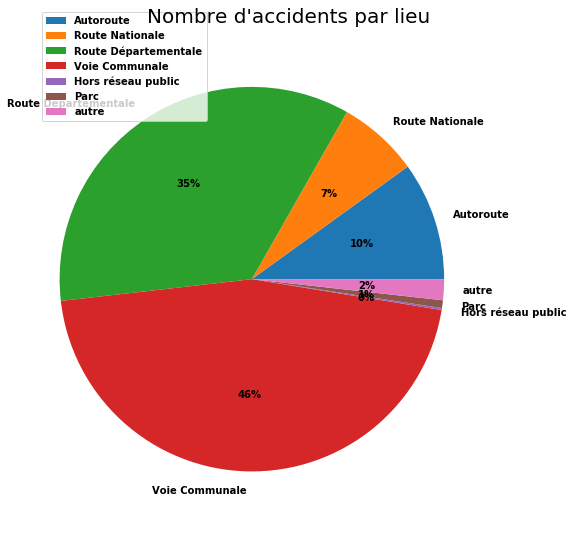

In [363]:
plt.pie(size, labels=labels, autopct='%1.0f%%')
l = plt.legend(labels, loc="best")
for text in l.get_texts():
    text.set_color("black")
fig = plt.gcf()
fig.set_size_inches(8,8)
plt.axis('equal')
plt.tight_layout()
fig.suptitle("Nombre d'accidents par lieu", fontsize=20,color="black")

plt.show()

In [364]:
lieux['nbv']

0        2.0
1        2.0
2        2.0
3        2.0
4        1.0
        ... 
55629    1.0
55630    2.0
55631    2.0
55632    2.0
55633    2.0
Name: nbv, Length: 55634, dtype: float64

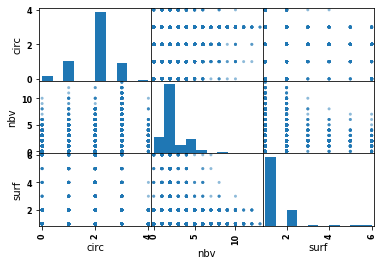

In [365]:
scatter_matrix(lieux.drop(columns=['Num_Acc']));

# Usagers

In [366]:
usagers.shape

(130169, 12)

In [367]:
len(usagers["Num_Acc"].unique())==usagers.shape[0]

False

> On remarque pour "usagers" que l'identifiant n'est pas unique et c'est légitime car  chaque accident peut impliquer plus qu'une personne.

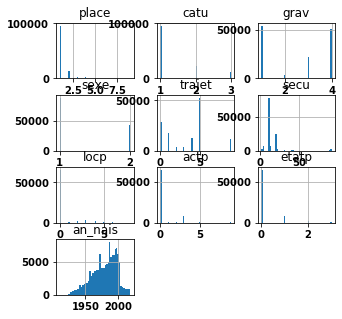

In [368]:
usagers.iloc[:,1:].hist(figsize=(5,5),bins=50);

In [369]:
usagers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130169 entries, 0 to 130168
Data columns (total 12 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   Num_Acc  130169 non-null  int64  
 1   place    119209 non-null  float64
 2   catu     130169 non-null  int64  
 3   grav     130169 non-null  int64  
 4   sexe     130169 non-null  int64  
 5   trajet   130055 non-null  float64
 6   secu     126040 non-null  float64
 7   locp     75518 non-null   float64
 8   actp     75523 non-null   float64
 9   etatp    75523 non-null   float64
 10  an_nais  130139 non-null  float64
 11  num_veh  130169 non-null  object 
dtypes: float64(7), int64(4), object(1)
memory usage: 11.9+ MB


Variables qualitatives :
- num_veh : Identifiant du véhicule repris pour chacun des usagers occupant ce véhicule 
- place : Permet de situer la place occupée dans le véhicule par l'usager au moment de l'accident
- catu : Catégorie d'usage
- grav : Gravité de l'accident
- sexe : Sexe de l’usager
- trajet : Motif du déplacement au moment de l’accident
- secu : Équipement de sécurité 
- locp : Localisation du piéton 
- actp : Action du piéton
- etatp : Cette variable permet de préciser si le piéton accidenté était seul ou non 

Variable quantitative :
- An_nais : Année de naissance de l’usager

In [370]:
for i in usagers.columns:
    print(usagers[i].describe())

count    1.301690e+05
mean     2.018000e+11
std      1.670913e+04
min      2.018000e+11
25%      2.018000e+11
50%      2.018000e+11
75%      2.018000e+11
max      2.018001e+11
Name: Num_Acc, dtype: float64
count    119209.000000
mean          1.444388
std           1.313743
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           9.000000
Name: place, dtype: float64
count    130169.000000
mean          1.346503
std           0.628362
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max           3.000000
Name: catu, dtype: float64
count    130169.000000
mean          2.527322
std           1.362546
min           1.000000
25%           1.000000
50%           3.000000
75%           4.000000
max           4.000000
Name: grav, dtype: float64
count    130169.000000
mean          1.322281
std           0.467352
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000

> Pour les variables : trajet,locp,etatp la valeur 0 est  utilisée pour dire que l'information n'est pas renseingée ou n'existe pas.


In [371]:
missing_usagers=usagers.isna().sum()
missing_usagers_perc=usagers.isna().sum()/usagers.shape[0]
df_info_usagers=pd.concat([missing_usagers,missing_usagers_perc],keys=['Values','Percentage'],axis=1)

In [372]:
df_info_usagers[df_info_usagers['Percentage']>0].sort_values(by=['Percentage'],ascending=False)

,Values,Percentage
locp,54651,0.419847
actp,54646,0.419808
etatp,54646,0.419808
place,10960,0.084198
secu,4129,0.031720
trajet,114,0.000876
an_nais,30,0.000230


C:\Users\Amin\Anaconda3\envs\GPU\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


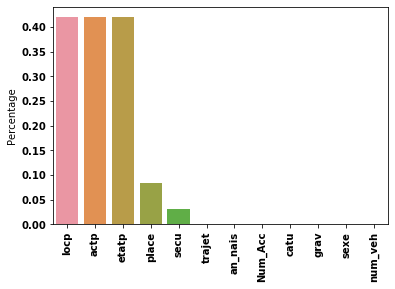

In [373]:
df_info_usagers=sns.barplot(df_info_usagers.sort_values(by=['Percentage'],ascending=False).index,df_info_usagers['Percentage'].sort_values(ascending=False))
df_info_usagers.set_xticklabels(df_info_usagers.get_xticklabels(),rotation=90);

In [374]:
usagers.isna().sum().sum()*100/(usagers.shape[0]*usagers.shape[1])

11.470729077839835

> Pour les variables trajet,locp,etatp le taux des valeurs nulles dépasses 40%, donc leur élimination et le meilleur choix.

In [375]:
for i in ["trajet","locp","etatp"]:
    del usagers[i]

##### Encodage

In [376]:
usagers['place'].value_counts()

1.0    96011
2.0    14465
3.0     2475
4.0     2049
9.0     1435
7.0     1297
8.0      688
5.0      610
6.0      179
Name: place, dtype: int64

In [377]:
usagers['place']= usagers['place'].replace({1 : "1", 2 : "2", 3 : "0", 4 : "0", 5 : "0",
                                      6 : "0", 7 : "0",8 : "0" ,9 : "0"})

In [378]:
usagers['place'].value_counts()

1    96011
2    14465
0     8733
Name: place, dtype: int64

In [379]:
usagers['catu'].value_counts()

1    96025
2    23184
3    10960
Name: catu, dtype: int64

In [380]:
usagers['grav'].value_counts()

1    54248
4    50360
3    22169
2     3392
Name: grav, dtype: int64

In [381]:
usagers['sexe'].value_counts()

1    88218
2    41951
Name: sexe, dtype: int64

In [382]:
usagers['secu'].value_counts()

11.0    77566
21.0    24118
3.0      7543
13.0     6703
2.0      2399
23.0     1574
12.0     1553
93.0     1370
31.0     1033
22.0      937
91.0      477
92.0      380
41.0      120
42.0      106
43.0      100
33.0       27
1.0        23
32.0       11
Name: secu, dtype: int64

In [383]:
usagers['secu']= usagers['secu'].replace({3 : "0", 11 : "2", 21 : "2", 13 : "0", 2 : "0",
                                      23 : "0", 12 : "1",93 : "0" ,31 : "2"
                                         , 22 : "1",91 : "2" ,92 : "1"
                                         , 41 : "2",42 : "1" ,43 : "0"
                                         , 33 : "0",1 : "0" ,32 : "1"})

In [384]:
usagers['secu'].value_counts()

2    103314
0     19739
1      2987
Name: secu, dtype: int64

In [385]:
usagers = usagers.drop(usagers[usagers['secu']=="0"].index)

In [386]:
usagers['actp'].value_counts()[0]*100/usagers['actp'].value_counts().sum()

93.35302562748561

> 93% des valeurs ne sont pas renseignées

In [387]:
del usagers['actp']

In [388]:
usagers['num_veh'].value_counts()

A01    64479
B01    39241
C01     4811
D01     1069
Z01      326
E01      256
F01       82
B02       41
R01       38
G01       29
H01       11
Y01       10
I01        9
T01        7
K01        4
J01        4
M01        4
L01        3
F02        2
A02        1
Z02        1
C03        1
C02        1
Name: num_veh, dtype: int64

> Le numéro de la voiture n'est pas important, de plus son encodage chargera beaucoup d'espace.

In [389]:
del usagers['num_veh']

In [390]:
quali=['place', 'catu', 'grav', 'sexe', 'secu']
for i in quali:
    usagers = usagers[usagers[i].notna()]
    usagers.reset_index(drop=True,inplace=True)

In [391]:
usagers.isna().sum()

Num_Acc     0
place       0
catu        0
grav        0
sexe        0
secu        0
an_nais    11
dtype: int64

In [392]:
usagers = usagers[usagers["an_nais"].notna()]
usagers.reset_index(drop=True,inplace=True)

In [393]:
age=[]
for i in usagers['an_nais']:
        age.append(2018 - i)

In [394]:
a={"age":age}

In [395]:
dfage=pd.DataFrame(a)

In [396]:
usagers=pd.concat([usagers,dfage],axis=1)

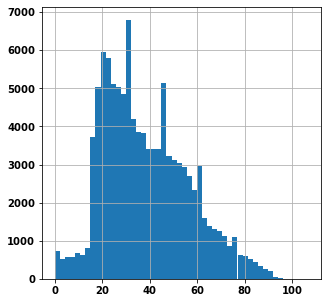

In [397]:
usagers['age'].hist(figsize=(5,5),bins=50);

In [398]:
print('Skewness : %f'% usagers['age'].skew())
print('Kurtosis : %f' % usagers['age'].kurt())

Skewness : 0.528126
Kurtosis : -0.261523


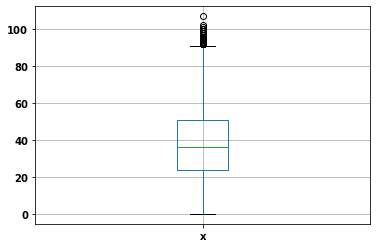

In [399]:
_, bp = pd.DataFrame.boxplot(usagers['age'], return_type='both')
outliers = [flier.get_ydata() for flier in bp["fliers"]]

In [400]:
usagers=usagers[usagers['age'].isin(outliers)==False]

In [401]:
del usagers['an_nais']

In [402]:
Indemne_A=usagers[(usagers['grav']==1)&(usagers['age'].isin(np.arange(0,25)))]['Num_Acc'].count()
Indemne_B=usagers[(usagers['grav']==1)&(usagers['age'].isin(np.arange(25,50)))]['Num_Acc'].count()
Indemne_C=usagers[(usagers['grav']==1)&(usagers['age'].isin(np.arange(50,75)))]['Num_Acc'].count()
Indemne_D=usagers[(usagers['grav']==1)&(usagers['age'].isin(np.arange(75,101)))]['Num_Acc'].count()

In [403]:
Tué_A=usagers[(usagers['grav']==2)&(usagers['age'].isin(np.arange(0,25)))]['Num_Acc'].count()
Tué_B=usagers[(usagers['grav']==2)&(usagers['age'].isin(np.arange(25,50)))]['Num_Acc'].count()
Tué_C=usagers[(usagers['grav']==2)&(usagers['age'].isin(np.arange(50,75)))]['Num_Acc'].count()
Tué_D=usagers[(usagers['grav']==2)&(usagers['age'].isin(np.arange(75,101)))]['Num_Acc'].count()

In [404]:
Blessé_hospitalisé_A=usagers[(usagers['grav']==3)&(usagers['age'].isin(np.arange(0,25)))]['Num_Acc'].count()
Blessé_hospitalisé_B=usagers[(usagers['grav']==3)&(usagers['age'].isin(np.arange(25,50)))]['Num_Acc'].count()
Blessé_hospitalisé_C=usagers[(usagers['grav']==3)&(usagers['age'].isin(np.arange(50,75)))]['Num_Acc'].count()
Blessé_hospitalisé_D=usagers[(usagers['grav']==3)&(usagers['age'].isin(np.arange(75,101)))]['Num_Acc'].count()

In [405]:
Blessé_léger_A=usagers[(usagers['grav']==4)&(usagers['age'].isin(np.arange(0,25)))]['Num_Acc'].count()
Blessé_léger_B=usagers[(usagers['grav']==4)&(usagers['age'].isin(np.arange(25,50)))]['Num_Acc'].count()
Blessé_léger_C=usagers[(usagers['grav']==4)&(usagers['age'].isin(np.arange(50,75)))]['Num_Acc'].count()
Blessé_léger_D=usagers[(usagers['grav']==4)&(usagers['age'].isin(np.arange(75,101)))]['Num_Acc'].count()

In [406]:
labels=["Indemne","Blessé léger","Blessé hospitalisé","Tué"]

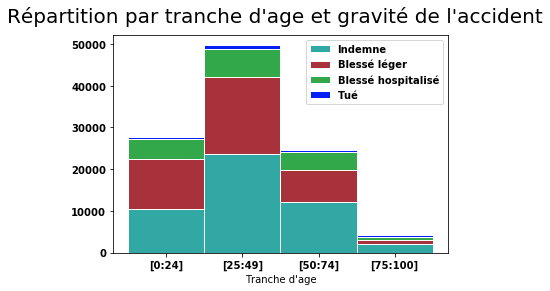

In [407]:
rc('font', weight='bold')
 
bars1 = [Indemne_A, Indemne_B, Indemne_C,Indemne_D]
bars4 = [Tué_A, Tué_B, Tué_C, Tué_D]
bars3 = [Blessé_hospitalisé_A, Blessé_hospitalisé_B, Blessé_hospitalisé_C, Blessé_hospitalisé_D]
bars2 = [Blessé_léger_A, Blessé_léger_B, Blessé_léger_C, Blessé_léger_D]

bars = np.add(bars1, bars2).tolist()
barslast = np.add(bars, bars3).tolist()


r = [0,1,2,3]

names = ['[0:24]','[25:49]','[50:74]','[75:100]']
barWidth = 1

plt.bar(r, bars1, color='#32a8a4', edgecolor='white', width=barWidth)

plt.bar(r, bars2, bottom=bars1, color='#a8323c', edgecolor='white', width=barWidth)

plt.bar(r, bars3, bottom=bars, color='#32a84a', edgecolor='white', width=barWidth)

plt.bar(r, bars4, bottom=barslast, color='#021ffa', edgecolor='white', width=barWidth)

 
plt.xticks(r, names, fontweight='bold')
plt.xlabel("Tranche d'age")

l = plt.legend(labels, loc="best")
for text in l.get_texts():
    text.set_color("black")
fig = plt.gcf()
fig.suptitle("Répartition par tranche d'age et gravité de l'accident", fontsize=20,color="black")     
plt.show()


In [408]:
homme=usagers[usagers['sexe']==1]['Num_Acc'].count()
femme=usagers[usagers['sexe']==2]['Num_Acc'].count()

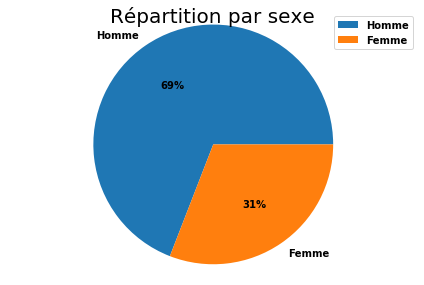

In [409]:
size=[homme,femme]
labels=["Homme","Femme"]

plt.pie(size, labels=labels, autopct='%1.0f%%')
l = plt.legend(labels, loc="best")
for text in l.get_texts():
    text.set_color("black")
fig = plt.gcf()
fig.suptitle("Répartition par sexe", fontsize=20,color="black")    
plt.axis('equal')
plt.tight_layout()
plt.show()

In [410]:
usagers

,Num_Acc,place,catu,grav,sexe,secu,age
0,201800000001,1,1,3,1,2,90.0
1,201800000001,1,1,1,1,2,58.0
2,201800000002,1,1,1,1,2,71.0
3,201800000003,1,1,3,1,2,31.0
4,201800000004,1,1,1,1,2,36.0
...,...,...,...,...,...,...,...
106051,201800057781,1,1,1,1,2,29.0
106052,201800057782,1,1,4,2,2,25.0
106053,201800057782,1,1,4,1,2,44.0
106054,201800057783,1,1,4,1,2,45.0


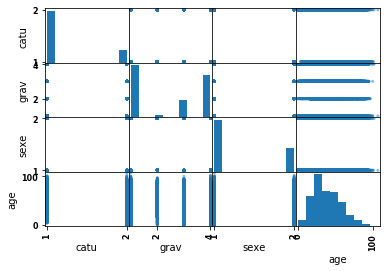

In [411]:
scatter_matrix(usagers.iloc[:,1:]);

# Véhicule

In [412]:
vehicules.shape

(98876, 9)

In [413]:
len(vehicules["Num_Acc"].unique())==vehicules.shape[0]

False

> On remarque pour "vehicules" que l'identifiant n'est pas unique et c'est normal car un accident peut impliqué plus que 2 voitures.

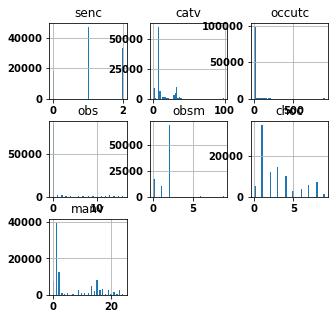

In [414]:
vehicules.iloc[:,1:].hist(figsize=(5,5),bins=50);

In [415]:
vehicules.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98876 entries, 0 to 98875
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Num_Acc  98876 non-null  int64  
 1   senc     98744 non-null  float64
 2   catv     98876 non-null  int64  
 3   occutc   98876 non-null  int64  
 4   obs      98687 non-null  float64
 5   obsm     98741 non-null  float64
 6   choc     98743 non-null  float64
 7   manv     98744 non-null  float64
 8   num_veh  98876 non-null  object 
dtypes: float64(5), int64(3), object(1)
memory usage: 6.8+ MB


Variables qualitatives :
- num_veh :Identifiant du véhicule
- senc : Sens de circulation
- catv : Catégorie du véhicule
- obs : Obstacle fixe heurté
- obsm : Obstacle mobile heurté
- choc : Point de choc initial
- manv : Manœuvre principale avant l’accident

Variable quantitative :
- occutc : Nombre d’occupants dans le transport en commun 

In [416]:
for i in vehicules.columns:
    print(vehicules[i].describe())

count    9.887600e+04
mean     2.018000e+11
std      1.674375e+04
min      2.018000e+11
25%      2.018000e+11
50%      2.018000e+11
75%      2.018000e+11
max      2.018001e+11
Name: Num_Acc, dtype: float64
count    98744.000000
mean         1.148809
std          0.705873
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          2.000000
Name: senc, dtype: float64
count    98876.000000
mean        12.484425
std         12.863464
min          1.000000
25%          7.000000
50%          7.000000
75%         10.000000
max         99.000000
Name: catv, dtype: float64
count    98876.000000
mean         0.148145
std          4.029273
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        900.000000
Name: occutc, dtype: float64
count    98687.000000
mean         1.001368
std          3.102252
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         16.000000
Name: o

> Pour les variables : senc,obs,obsm,choc,manv la valeur 0 est utilisé pour dire que l'information n'est pas renseingée ou n'existe pas.

In [417]:
missing_vehicules=vehicules.isna().sum()
missing_vehicules_perc=vehicules.isna().sum()/vehicules.shape[0]
df_info_vehicules=pd.concat([missing_vehicules,missing_vehicules_perc],keys=['Values','Percentage'],axis=1)

In [418]:
df_info_vehicules[df_info_vehicules['Percentage']>0].sort_values(by=['Percentage'],ascending=False)

,Values,Percentage
obs,189,0.001911
obsm,135,0.001365
choc,133,0.001345
senc,132,0.001335
manv,132,0.001335


C:\Users\Amin\Anaconda3\envs\GPU\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


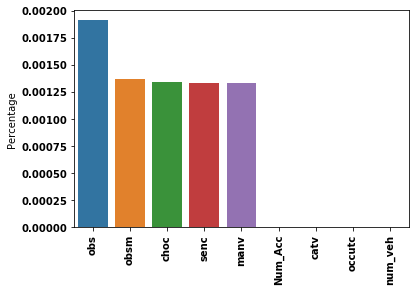

In [419]:
plot_vehicules_info=sns.barplot(df_info_vehicules.sort_values(by=['Percentage'],ascending=False).index,df_info_vehicules['Percentage'].sort_values(ascending=False))
plot_vehicules_info.set_xticklabels(plot_vehicules_info.get_xticklabels(),rotation=90);

In [420]:
vehicules.isna().sum().sum()*100/(vehicules.shape[0]*vehicules.shape[1])

0.08102179609926687

> Le pourcentage des valeurs nulles n'est pas important.

In [421]:
for i in vehicules.columns:
    vehicules = vehicules[vehicules[i].notna()]
    vehicules.reset_index(drop=True,inplace=True)

In [422]:
vehicules.columns

Index(['Num_Acc', 'senc', 'catv', 'occutc', 'obs', 'obsm', 'choc', 'manv',
       'num_veh'],
      dtype='object')

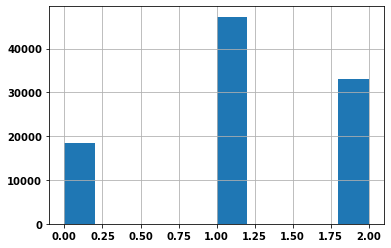

In [423]:
vehicules['senc'].hist();

In [424]:
vehicules['senc'].value_counts()

1.0    47253
2.0    33004
0.0    18326
Name: senc, dtype: int64

In [425]:
vehicules = vehicules.drop(vehicules[vehicules['senc']==0].index)

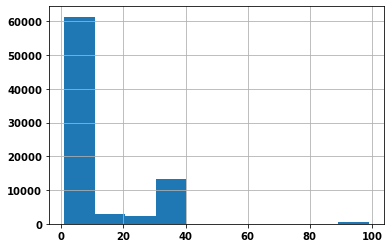

In [426]:
vehicules['catv'].hist();

In [427]:
vehicules['catv'].value_counts()

7     49272
33     6975
10     5358
1      3541
2      2861
30     2164
31     2091
32     1671
34     1530
15      885
17      861
14      680
37      546
99      489
13      342
3       300
21      158
38      149
20      126
40       99
36       79
16       47
35       17
39       16
Name: catv, dtype: int64

In [428]:
vehicules['catv']= vehicules['catv'].replace({99: 0,1:1,2:1,3:1,4:1,5:1,6:1,30:1,31:1,32:1,33:1,34:1,35:1,36:1,
                                     7:2,8:2,10:2,9:2,11:2,12:2,16:2,20:2,21:2,
                                      13:3,14:3,15:3,17:3,18:3,19:3,37:3,38:3,39:3,40:3})

In [429]:
vehicules['catv'].value_counts()

2    54961
1    21229
3     3578
0      489
Name: catv, dtype: int64

> Encodage selon le poids

In [430]:
vehicules[vehicules['occutc']==0]['Num_Acc'].count()*100/vehicules['occutc'].value_counts().sum()

99.17639582840125

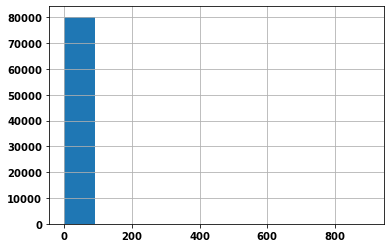

In [431]:
vehicules['occutc'].hist();

> 99% des vaeurs sont nulles, c'est normal vu que la variable est destiné pour le transport en commun .

In [432]:
del vehicules['occutc']

In [433]:
vehicules[vehicules['obs']==0]['Num_Acc'].count()*100/vehicules['obs'].value_counts().sum()

85.41435638012884

> 85% des données sont non renseignées.

In [434]:
del vehicules['obs']

In [435]:
vehicules['obsm'].value_counts()

2.0    57272
0.0    13739
1.0     7831
9.0      776
6.0      502
4.0       69
5.0       68
Name: obsm, dtype: int64

In [436]:
vehicules = vehicules.drop(vehicules[vehicules['obsm']==0].index)
vehicules.reset_index(drop=True,inplace=True)

In [437]:
vehicules['obsm'].value_counts()

2.0    57272
1.0     7831
9.0      776
6.0      502
4.0       69
5.0       68
Name: obsm, dtype: int64

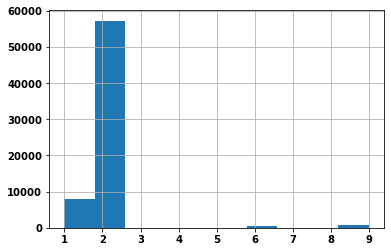

In [438]:
vehicules['obsm'].hist();

In [439]:
vehicules['obsm']= vehicules['obsm'].replace({1:"1",2:"2",4:"2",5:"3",6:"3",9:"0"})                                   

In [440]:
vehicules['choc'].value_counts()

1.0    24242
3.0    10493
2.0     8353
4.0     7731
8.0     4765
7.0     3833
6.0     2688
5.0     2111
0.0     1897
9.0      405
Name: choc, dtype: int64

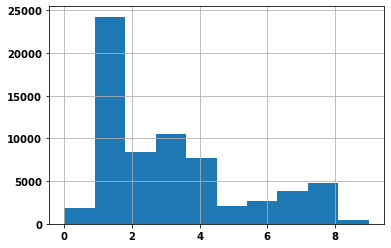

In [441]:
vehicules['choc'].hist();

In [442]:
vehicules = vehicules.drop(vehicules[vehicules['choc']==0].index)
vehicules.reset_index(drop=True,inplace=True)

In [443]:
vehicules['choc']= vehicules['choc'].replace({1:"1",2:"1",3:"1",4:"2",5:"2",6:"2",7:"3",8:"3",9:"0"})                                   

In [444]:
vehicules['choc'].value_counts()

1    43088
2    12530
3     8598
0      405
Name: choc, dtype: int64

In [445]:
vehicules['manv'].value_counts()

1.0     25554
2.0      9817
15.0     5700
0.0      3103
13.0     2954
17.0     2544
23.0     2166
9.0      1816
19.0     1646
16.0     1606
3.0       971
21.0      970
12.0      937
11.0      894
5.0       719
10.0      611
14.0      601
18.0      452
4.0       374
7.0       344
20.0      295
22.0      207
24.0      205
8.0        78
6.0        57
Name: manv, dtype: int64

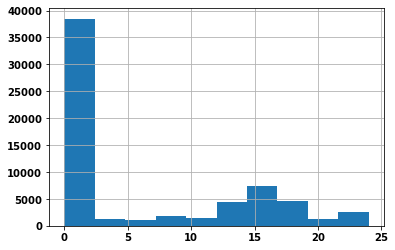

In [446]:
vehicules['manv'].hist();

In [447]:
vehicules = vehicules.drop(vehicules[vehicules['manv']==0].index)
vehicules.reset_index(drop=True,inplace=True)

In [448]:
vehicules['manv']= vehicules['manv'].replace({1:"1",2:"1",3:"1",4:"1",5:"1",6:"1",7:"1",8:"1",9:"1",10:"1",
                                     11:"2",12:"2",
                                     13:"3",14:"3",
                                     15:"4",16:"4",
                                     17:"5",18:"5",
                                      19:"6",20:"6",21:"6",22:"6",23:"6",24:"6"})

In [449]:
vehicules['manv'].value_counts()

1    40341
4     7306
6     5489
3     3555
5     2996
2     1831
Name: manv, dtype: int64

> Encodage selon le taux de présence

In [450]:
vehicules['num_veh']= vehicules['num_veh'].replace({"A01":3,"B01":3,
                                     "C01":2,"Z01":2,"D01":2,   
                                      "E01":1,"F01":1,"B02":1,"G01":1,"Y01":1,"H01":1,"M01":1,"Z02":1,"X01":1,"I01":1,"K01":1,"W01":1,"C02":1,"T01":1,"C03":1,"F02":1})

In [451]:
vehicules["num_veh"].value_counts()

3    56397
2     4826
1      295
Name: num_veh, dtype: int64

In [452]:
vehicules

,Num_Acc,senc,catv,obsm,choc,manv,num_veh
0,201800000018,2.0,1,2,1,1,3
1,201800000018,2.0,2,2,2,6,3
2,201800000020,2.0,2,2,1,1,3
3,201800000024,2.0,2,1,1,1,3
4,201800000027,2.0,2,2,1,1,3
...,...,...,...,...,...,...,...
61513,201800057778,2.0,2,2,1,1,3
61514,201800057779,1.0,1,1,3,6,3
61515,201800057780,1.0,1,2,2,6,3
61516,201800057780,1.0,2,2,1,1,3


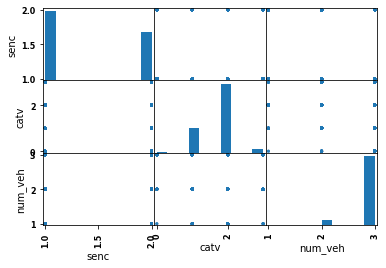

In [453]:
scatter_matrix(vehicules.iloc[:,1:]);

In [454]:
dfs=[lieux,usagers,vehicules,carac]

In [455]:
df_final = reduce(lambda left,right: pd.merge(left,right,on='Num_Acc'), dfs)

In [456]:
df_final['Target'] = df_final.groupby('catr')['Num_Acc'].transform('count')

In [457]:
del df_final['catr']

In [458]:
cat_carac=["mois", "lum","agg","int","col","jourSemaine","heure_pointe"]
prefix_cat_carac=["carac_mois", "carac_lum","carac_agg","carac_int","carac_col","carac_jourSemaine","carac_heure_pointe"]

cat_lieux=["nbv","circ","vosp","prof","plan","situ"]
prefix_cat_lieux=["lieux_nbv","lieux_circ","lieux_vosp","lieux_prof","lieux_plan","lieux_situ"]

cat_usagers=["place","catu","grav","sexe","secu"]
prefix_cat_usagers=["usagers_place","usagers_catu","usagers_grav","usagers_sex","usagers_secu"]

cat_vehicules=["catv","senc","obsm","choc","manv","num_veh"]
prefix_cat_vehicules=["vehicule_catv","vehicule_senc","vehicule_obsm","vehicule_choc","vehicule_manv","vehicule_num_veh"]

In [459]:
df_final=pd.get_dummies(df_final, columns=cat_carac,
               drop_first=True, prefix=prefix_cat_carac)

In [460]:
df_final=pd.get_dummies(df_final, columns=cat_lieux,
               drop_first=True, prefix=prefix_cat_lieux)

In [461]:
df_final=pd.get_dummies(df_final, columns=cat_usagers,
               drop_first=True, prefix=prefix_cat_usagers)

In [462]:
df_final=pd.get_dummies(df_final, columns=cat_vehicules,
               drop_first=True, prefix=prefix_cat_vehicules)

In [463]:
col=['Num_Acc', 'surf', 'age', 'atm', 'lat', 'long',
       'carac_mois_2', 'carac_mois_3', 'carac_mois_4', 'carac_mois_5',
       'carac_mois_6', 'carac_mois_7', 'carac_mois_8', 'carac_mois_9',
       'carac_mois_10', 'carac_mois_11', 'carac_mois_12', 'carac_lum_2',
       'carac_lum_3', 'carac_lum_4', 'carac_lum_5', 'carac_agg_2',
       'carac_int_2', 'carac_int_3', 'carac_int_4', 'carac_int_5',
       'carac_int_6', 'carac_col_1.0', 'carac_col_2.0', 'carac_col_3.0',
       'carac_jourSemaine_1', 'carac_jourSemaine_2', 'carac_jourSemaine_3',
       'carac_jourSemaine_4', 'carac_jourSemaine_5', 'carac_jourSemaine_6',
       'carac_heure_pointe_1', 'lieux_nbv_1.0', 'lieux_nbv_2.0',
       'lieux_nbv_3.0', 'lieux_nbv_4.0', 'lieux_nbv_5.0', 'lieux_nbv_6.0',
       'lieux_nbv_7.0', 'lieux_nbv_8.0', 'lieux_nbv_9.0', 'lieux_nbv_10.0',
       'lieux_nbv_11.0', 'lieux_nbv_12.0', 'lieux_nbv_13.0', 'lieux_circ_1.0',
       'lieux_circ_2.0', 'lieux_circ_3.0', 'lieux_circ_4.0', 'lieux_vosp_1',
       'lieux_prof_2', 'lieux_prof_3', 'lieux_plan_2', 'lieux_plan_3',
       'lieux_situ_2', 'lieux_situ_3', 'usagers_place_1', 'usagers_place_2',
       'usagers_catu_2', 'usagers_grav_2', 'usagers_grav_3', 'usagers_grav_4',
       'usagers_sex_2', 'usagers_secu_2', 'vehicule_catv_1', 'vehicule_catv_2',
       'vehicule_catv_3', 'vehicule_senc_2.0', 'vehicule_obsm_1',
       'vehicule_obsm_2', 'vehicule_obsm_3', 'vehicule_choc_1',
       'vehicule_choc_2', 'vehicule_choc_3', 'vehicule_manv_2',
       'vehicule_manv_3', 'vehicule_manv_4', 'vehicule_manv_5',
       'vehicule_manv_6', 'vehicule_num_veh_2', 'vehicule_num_veh_3', 'Target']

In [464]:
df_final = df_final.reindex(columns=col)

In [465]:
X = df_final.iloc[:,1:86]
y = df_final.drop(columns=X.columns).iloc[:,1:]

In [466]:
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)

# Machine learning

In [467]:
#f1=make_scorer(f1_score , average='macro')

In [468]:
#gsparam = {
 #'n_estimators':[50,100,150,200],
 #'max_depth':[2,3,4,5,6,7,8,9],
 #'min_child_weight':[2,3,4,5],
 #'colsample_bytree':[0.2,0.6,0.8],
 #'colsample_bylevel':[0.2,0.6,0.8]
#}

In [469]:
#gs = GridSearchCV(estimator = XGBClassifier( 
       # objective= 'reg:linear', 
        #seed=1), 
    #param_grid = gsparam, 
    #scoring=f1,
    #cv=5,
    #verbose = 1)
#gs.fit(X, y)
#param = gs.bestparams
#param['objective'] = 'reg:linear'

In [470]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [471]:
param = {
 #'n_estimators':50,
 #'max_depth':6,
 #'min_child_weight':2,
 #'colsample_bytree':0.2,
 #'colsample_bylevel':0.2,
 'objective':'reg:linear'
}

In [472]:
model = XGBClassifier(**param)
model.fit(X_train, y_train)

C:\Users\Amin\Anaconda3\envs\GPU\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [473]:
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

In [474]:
f1 = f1_score(y_test, predictions,average='macro')
print("F1: %.2f%%" % (f1 * 100.0))

F1: 85.30%


In [475]:
classes=["47161","46365","24814","13320","1187","132","30"]

In [476]:
print(classification_report(y_test, predictions, target_names=classes))

              precision    recall  f1-score   support

       47161       1.00      0.50      0.67         6
       46365       0.92      0.80      0.86        30
       24814       0.98      0.70      0.82       251
       13320       0.94      0.80      0.86      2739
        1187       0.96      0.99      0.97      4915
         132       0.89      0.92      0.90      9167
          30       0.89      0.89      0.89      9496

    accuracy                           0.91     26604
   macro avg       0.94      0.80      0.85     26604
weighted avg       0.91      0.91      0.91     26604



# MAP

In [477]:
import os
import folium
import geopandas as gpd
import earthpy as et

In [478]:
os.chdir(os.path.join(et.io.HOME, 'earth-analytics'))


In [479]:
data = et.data.get_data('spatial-vector-lidar')
os.chdir(os.path.join(et.io.HOME, 'earth-analytics'))

In [480]:
latlon = []
#for i in range(carac.shape[0]):     # Performances de la machine sont limitées
for i in range(0,500):
    l=(int(carac['lat'][i])/100000,int(carac['long'][i])/100000)
    latlon.append(l)

In [481]:
mapit = folium.Map( location=[48.8534, 2.3488], zoom_start=6 )
for coord in latlon:
    folium.Marker( location=[ coord[0], coord[1] ], fill_color='#43d9de', radius=8 ).add_to( mapit )
mapit